First try for data analytics for the csgo data after ETL v1

# Install Required Libraries
Use pip to install necessary libraries such as psycopg2 or sqlalchemy.

In [35]:
# Install Required Libraries
# Uncomment the following lines to install the required libraries
# !pip install psycopg2-binary
# !pip install sqlalchemy

# Import Libraries
Import libraries like psycopg2, sqlalchemy, and pandas for database connection and data manipulation.

In [36]:
# Import Libraries
import psycopg2
import pandas as pd

# Set Up Database Connection
Establish a connection to the PostgreSQL database using connection parameters such as host, database name, user, and password.

In [37]:
# Set Up Database Connection
# Replace the placeholders with your actual database credentials
DB_CONFIG = {
    "dbname": "csgo_parsed",
    "user": "csgo_parser",
    "password": "3?6B7yTGPrkJF34p",
    "host": "192.168.1.100",
    "port": "5444"
}

# Using psycopg2
try:
    connection = psycopg2.connect(**DB_CONFIG)
    print("Connection to PostgreSQL database successful")
except Exception as e:
    print(f"Error: {e}")



Connection to PostgreSQL database successful


# Query the PostgreSQL Table
Write and execute a SQL query to fetch data from the desired table.

In [38]:
# Query the PostgreSQL Table
query = """
SELECT      
        score1_start, score2_start, score1_end, score2_end, winner_team, winner_side, round_num, match_id, map_number,
        t1_p1_money_spent, t1_p2_money_spent, t1_p3_money_spent, t1_p4_money_spent, t1_p5_money_spent,
        t2_p1_money_spent, t2_p2_money_spent, t2_p3_money_spent, t2_p4_money_spent, t2_p5_money_spent,
        t1_p1_eq_val_start, t1_p2_eq_val_start, t1_p3_eq_val_start, t1_p4_eq_val_start, t1_p5_eq_val_start,
        t2_p1_eq_val_start, t2_p2_eq_val_start, t2_p3_eq_val_start, t2_p4_eq_val_start, t2_p5_eq_val_start,
        t1_p1_eq_val_ft_end, t1_p2_eq_val_ft_end, t1_p3_eq_val_ft_end, t1_p4_eq_val_ft_end, t1_p5_eq_val_ft_end,
        t2_p1_eq_val_ft_end, t2_p2_eq_val_ft_end, t2_p3_eq_val_ft_end, t2_p4_eq_val_ft_end, t2_p5_eq_val_ft_end
FROM round_info_etl_v1
"""

try:
    # Execute the query
    cursor = connection.cursor()
    cursor.execute(query)
    results = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    
    # Load the results into a DataFrame
    df = pd.DataFrame(results, columns=columns)
    
    # Calculate total money spent per team
    df['team1_total_spent'] = (
        df['t1_p1_money_spent'] + df['t1_p2_money_spent'] + 
        df['t1_p3_money_spent'] + df['t1_p4_money_spent'] + 
        df['t1_p5_money_spent']
    )
    df['team2_total_spent'] = (
        df['t2_p1_money_spent'] + df['t2_p2_money_spent'] + 
        df['t2_p3_money_spent'] + df['t2_p4_money_spent'] + 
        df['t2_p5_money_spent']
    )
    
    df['spending_diff'] = df['team1_total_spent'] - df['team2_total_spent']
    
    # Display the first few rows of the DataFrame
    print(df[['team1_total_spent', 'team2_total_spent']].head())
    
except Exception as e:
    print(f"Error: {e}")
finally:
    # Close the cursor and connection
    cursor.close()
    connection.close()

   team1_total_spent  team2_total_spent
0             3250.0             2650.0
1              800.0             9600.0
2             3750.0            14000.0
3            15400.0            23300.0
4            21850.0            22450.0


In [39]:
import numpy as np
from scipy.stats import pointbiserialr

# Encode winner_team as binary (e.g., 1 for team1, 0 for team2)
df['winner_team_binary'] = np.where(df['winner_team'] == 1, 1, 0)

# Remove rows with NaN or inf values in the relevant columns
filtered_df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['spending_diff', 'winner_team_binary'])

# Calculate correlation
correlation, p_value = pointbiserialr(filtered_df['spending_diff'], filtered_df['winner_team_binary'])
print(f"Correlation: {correlation}, P-value: {p_value}")

Correlation: 0.20113207531660615, P-value: 0.0


In [40]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Boxplot
# sns.boxplot(x='winner_team', y='spending_diff', data=df)
# plt.title('Spending Difference vs Round Outcome')
# plt.show()

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Prepare data
X = df[['spending_diff']]
y = df['winner_team_binary']

# Drop rows with NaN values in X or y
X = X.dropna()
y = y[X.index]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.6079534373036111


In [42]:
df['team1_total_spent'].mean(), df['team2_total_spent'].mean(), df['spending_diff'].mean(), df['winner_team_binary'].mean()

(np.float64(14248.849735096228),
 np.float64(14289.975309408914),
 np.float64(-40.81327702368372),
 np.float64(0.49237382784719796))

In [43]:
# Get the last round for each match_id and map_number
last_round_scores = df.loc[df.groupby(['match_id', 'map_number'])['round_num'].idxmax(), ['match_id', 'map_number', 'score1_end', 'score2_end']]

# Reset the index for better readability
last_round_scores = last_round_scores.reset_index(drop=True)

# Display the results
print(last_round_scores)

        match_id  map_number  score1_end  score2_end
0        2291374           1        16.0         2.0
1        2291377           1        16.0         1.0
2        2291412           1        16.0         2.0
3        2291445           1        12.0        16.0
4        2291526           1         7.0        16.0
...          ...         ...         ...         ...
110014   2367064           1         9.0        16.0
110015   2367064           2         9.0        16.0
110016   2367066           1        16.0        10.0
110017   2367066           2         9.0        16.0
110018   2367066           3        10.0        16.0

[110019 rows x 4 columns]


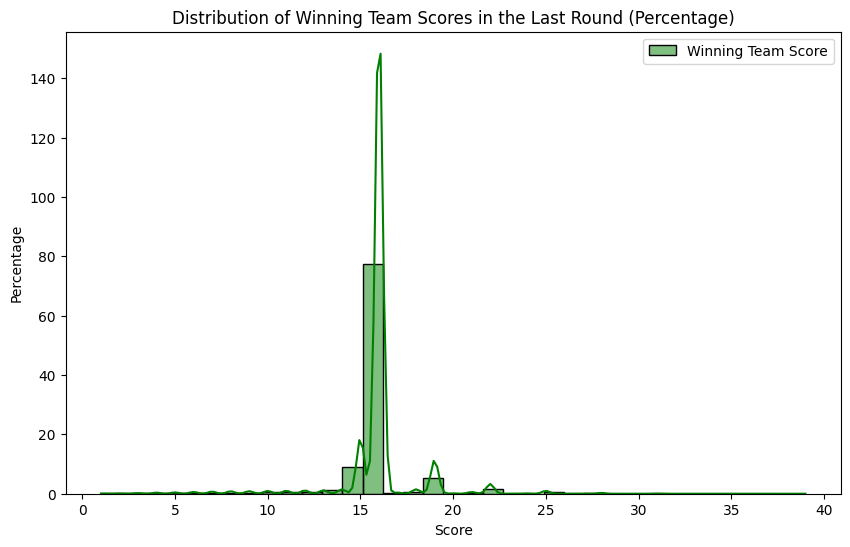

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that the earlier cells defining 'df' have been executed before running this cell.

# Get the last round for each match_id and map_number
last_round_scores = df.loc[df.groupby(['match_id', 'map_number'])['round_num'].idxmax(), ['winner_team', 'score1_end', 'score2_end']]

# Create a new column for the winning team's score
last_round_scores['winning_team_score'] = last_round_scores.apply(
    lambda row: row['score1_end'] if row['winner_team'] == 1 else row['score2_end'], axis=1
)

# Plot the distribution of winning team scores as percentages
plt.figure(figsize=(10, 6))
sns.histplot(last_round_scores['winning_team_score'], kde=True, color='green', label='Winning Team Score', bins=35, stat='percent')
plt.title('Distribution of Winning Team Scores in the Last Round (Percentage)')
plt.xlabel('Score')
plt.ylabel('Percentage')
plt.legend()
plt.show()

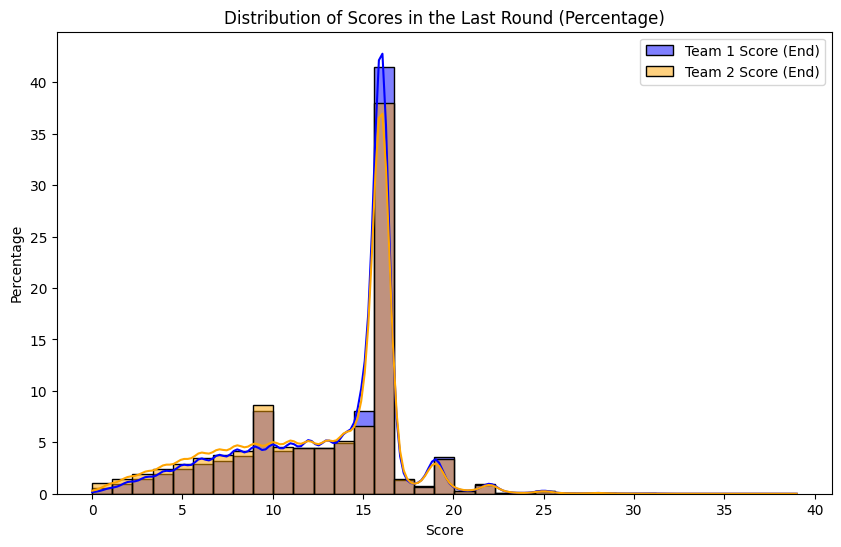

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the last round for each match_id and map_number
last_round_scores = df.loc[df.groupby(['match_id', 'map_number'])['round_num'].idxmax(), ['score1_end', 'score2_end']]

# Plot the distribution of scores as percentages
plt.figure(figsize=(10, 6))
sns.histplot(last_round_scores['score1_end'], kde=True, color='blue', label='Team 1 Score (End)', bins=35, stat='percent')
sns.histplot(last_round_scores['score2_end'], kde=True, color='orange', label='Team 2 Score (End)', bins=35, stat='percent')
plt.title('Distribution of Scores in the Last Round (Percentage)')
plt.xlabel('Score')
plt.ylabel('Percentage')
plt.legend()
plt.show()

In [46]:
# Query to fetch team1_hltv_rank and team2_hltv_rank
rank_query = """
SELECT match_id, map_number, team1_hltv_rank, team2_hltv_rank
FROM match_info_etl_v1
"""

try:
    # Re-establish the database connection
    connection = psycopg2.connect(**DB_CONFIG)
    cursor = connection.cursor()
    
    # Execute the query
    cursor.execute(rank_query)
    rank_results = cursor.fetchall()
    rank_columns = [desc[0] for desc in cursor.description]
    
    # Load the results into a DataFrame
    rank_df = pd.DataFrame(rank_results, columns=rank_columns)
    
    # Merge the rank data with the existing DataFrame
    df = df.merge(rank_df, on=['match_id', 'map_number'], how='left')
    
    # Drop rows with NaN values in the new columns
    df = df.dropna(subset=['team1_hltv_rank', 'team2_hltv_rank'])
    
    # Add the new columns to the regression
    X = df[['team1_total_eq_val_start', 'team2_total_eq_val_start', 'team1_total_spent', 
            'team2_total_spent', 'team1_hltv_rank', 'team2_hltv_rank']]
    y = df['winner_team_binary']
    
    # Drop rows with NaN values in X or y
    X = X.dropna()
    y = y[X.index]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train linear regression
    regression_model = LinearRegression()
    regression_model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = regression_model.predict(X_test)
    
    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    
    # Display the coefficients
    coefficients = regression_model.coef_
    print(f"Coefficients: {coefficients}")
    
    # Display the intercept
    intercept = regression_model.intercept_
    print(f"Intercept: {intercept}")
    
    # Calculate R-squared value
    r_squared = regression_model.score(X_test, y_test)
    print(f"R-squared: {r_squared}")
    
    # Analyze the coefficients in detail
    feature_names = X.columns
    coefficients_dict = dict(zip(feature_names, coefficients))
    print("Feature Coefficients:")
    for feature, coef in coefficients_dict.items():
        print(f"{feature}: {coef}")
    
    # Calculate p-values for the features
    _, p_values = f_regression(X, y)
    
    # Display the p-values
    p_values_dict = dict(zip(X.columns, p_values))
    print("Feature P-values:")
    for feature, p_val in p_values_dict.items():
        print(f"{feature}: {p_val}")

except Exception as e:
    print(f"Error: {e}")
finally:
    if cursor:
        cursor.close()
    if connection:
        connection.close()


Error: "['team1_total_eq_val_start', 'team2_total_eq_val_start'] not in index"


In [47]:
# Add binary variables team1_ct and team2_ct
df['team1_ct'] = ((df['winner_side'] == df['winner_team']) & (df['winner_team'] == 1)).astype(int)
df['team2_ct'] = ((df['winner_side'] == df['winner_team']) & (df['winner_team'] == 2)).astype(int)

df['rank_diff'] = df['team1_hltv_rank'] - df['team2_hltv_rank']

# Prepare data for logistic regression
X = df[['spending_diff', 'team1_ct', 'team2_ct', 'rank_diff', 
         'team1_total_spent', 'team2_total_spent']]
y = df['winner_team_binary']

# Drop rows with NaN values in X or y
X = X.dropna()
y = y[X.index]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.819298804487188


In [48]:
# Analyze Coefficients Importance
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Extract coefficients and feature names
coefficients = model.coef_[0]
feature_names = X.columns

# Create a DataFrame for better visualization
coeff_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
coeff_df['Absolute_Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Absolute_Coefficient', ascending=False)

# Display the most important coefficients
print("Most Important Coefficients:")
print(coeff_df)

# Correlation Analysis
correlation_results = {}
for feature in feature_names:
    correlation, p_value = pearsonr(X[feature], y)
    correlation_results[feature] = {"Correlation": correlation, "P-value": p_value}

# Convert correlation results to a DataFrame
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index')
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

# Display the correlation results
print("Feature Correlations:")
print(correlation_df)

Most Important Coefficients:
             Feature  Coefficient  Absolute_Coefficient
1           team1_ct    10.986075             10.986075
2           team2_ct   -10.170061             10.170061
3          rank_diff    -0.002429              0.002429
0      spending_diff     0.000025              0.000025
5  team2_total_spent    -0.000017              0.000017
4  team1_total_spent     0.000008              0.000008
Feature Correlations:
                   Correlation  P-value
team1_ct              0.614834      0.0
spending_diff         0.198118      0.0
team1_total_spent     0.110753      0.0
rank_diff            -0.072367      0.0
team2_total_spent    -0.107146      0.0
team2_ct             -0.593782      0.0


In [49]:
# Define spending levels based on quantiles
spending_bins_1 = [-float('inf'), df['team1_total_spent'].quantile(0.33), df['team1_total_spent'].quantile(0.66), float('inf')]
spending_bins_2 = [-float('inf'), df['team2_total_spent'].quantile(0.33), df['team2_total_spent'].quantile(0.66), float('inf')]
spending_labels = ['Low', 'Medium', 'High']

# Categorize spending_diff into levels
df['team1_total_spent_cat'] = pd.cut(df['team1_total_spent'], bins=spending_bins_1, labels=spending_labels)
df['team2_total_spent_cat'] = pd.cut(df['team2_total_spent'], bins=spending_bins_2, labels=spending_labels)

# One-hot encode the spending levels
spending_dummies_1 = pd.get_dummies(df['team1_total_spent_cat'], prefix='t1_spending_level')
spending_dummies_2 = pd.get_dummies(df['team2_total_spent_cat'], prefix='t2_spending_level')

# Add the one-hot encoded columns to the DataFrame
df = pd.concat([df, spending_dummies_1], axis=1)
df = pd.concat([df, spending_dummies_2], axis=1)

# Prepare data for logistic regression
X = df[['t1_spending_level_Low', 't1_spending_level_Medium', 't1_spending_level_High', 't1_spending_level_Low', 't1_spending_level_Medium', 't1_spending_level_High',
         'team1_ct', 'team2_ct', 'rank_diff']]
y = df['winner_team_binary']

# Drop rows with NaN values in X or y
X = X.dropna()
y = y[X.index]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Analyze coefficients
coefficients = model.coef_[0]
feature_names = X.columns
coeff_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
coeff_df['Absolute_Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Absolute_Coefficient', ascending=False)

print("Most Important Coefficients:")
print(coeff_df)

Accuracy: 0.8010274638889034
Most Important Coefficients:
                    Feature  Coefficient  Absolute_Coefficient
6                  team1_ct    10.755575             10.755575
7                  team2_ct   -10.339478             10.339478
1  t1_spending_level_Medium     2.917661              2.917661
4  t1_spending_level_Medium     2.917661              2.917661
5    t1_spending_level_High     2.738866              2.738866
2    t1_spending_level_High     2.738866              2.738866
0     t1_spending_level_Low     2.527646              2.527646
3     t1_spending_level_Low     2.527646              2.527646
8                 rank_diff    -0.002426              0.002426


In [50]:
# Team 1 spending level cutoffs
spending_bins_1 = [-float('inf'), df['team1_total_spent'].quantile(0.33), df['team1_total_spent'].quantile(0.66), float('inf')]
print(f"Team 1 spending level cutoffs: {spending_bins_1}")

# Team 2 spending level cutoffs
spending_bins_2 = [-float('inf'), df['team2_total_spent'].quantile(0.33), df['team2_total_spent'].quantile(0.66), float('inf')]
print(f"Team 2 spending level cutoffs: {spending_bins_2}")

Team 1 spending level cutoffs: [-inf, np.float64(9800.0), np.float64(17950.0), inf]
Team 2 spending level cutoffs: [-inf, np.float64(9850.0), np.float64(18000.0), inf]


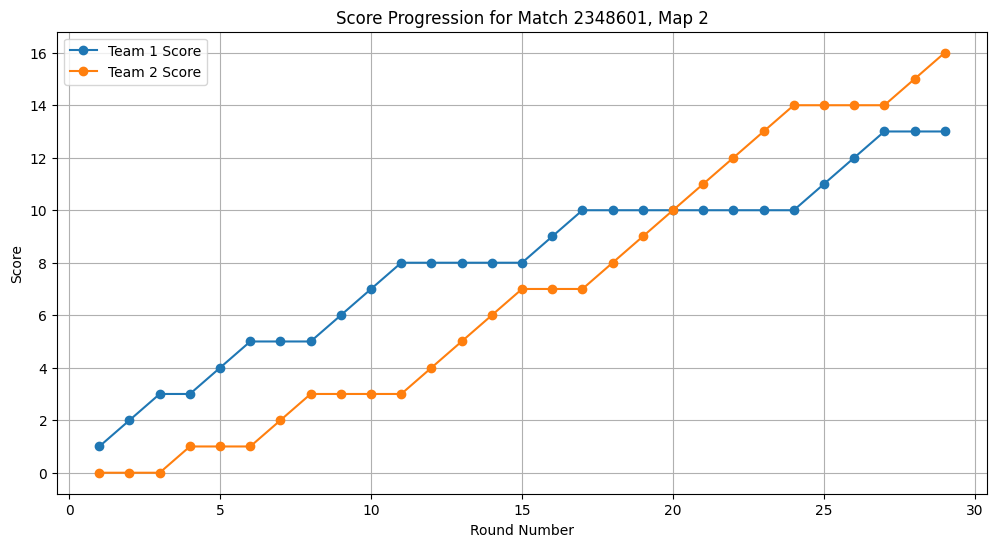

In [51]:
import matplotlib.pyplot as plt

# Filter data for a specific match_id and map_number for clarity
example_match_id = df['match_id'].iloc[0]
example_map_number = df['map_number'].iloc[0]
filtered_game = df[(df['match_id'] == example_match_id) & (df['map_number'] == example_map_number)]

# Order the rounds in ascending order
filtered_game = filtered_game.sort_values(by='round_num')

# Plot the score progression
plt.figure(figsize=(12, 6))
plt.plot(filtered_game['round_num'], filtered_game['score1_end'], label='Team 1 Score', marker='o')
plt.plot(filtered_game['round_num'], filtered_game['score2_end'], label='Team 2 Score', marker='o')

# Add labels and title
plt.title(f'Score Progression for Match {example_match_id}, Map {example_map_number}')
plt.xlabel('Round Number')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\peter\AppData\Local\Temp\ipykernel_84212\914684676.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


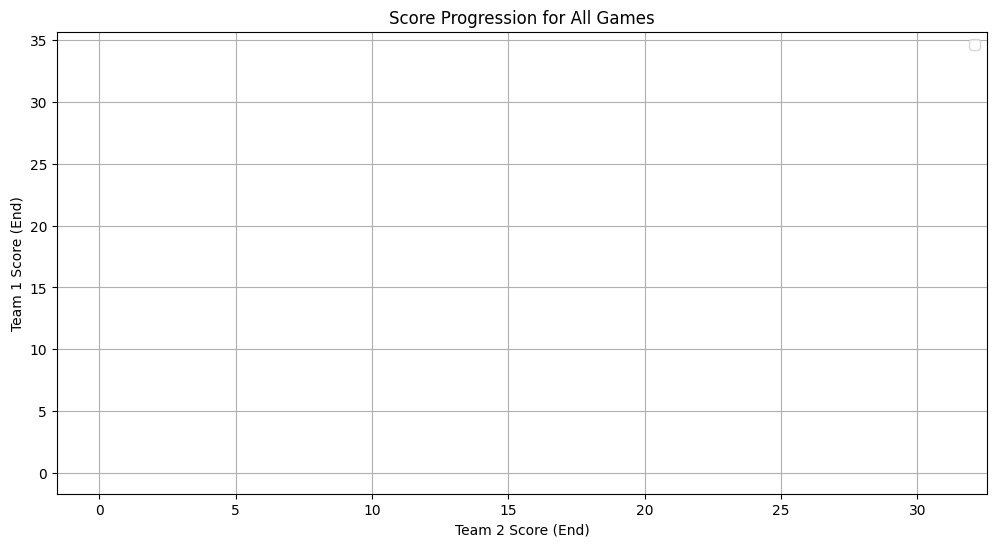

In [ ]:
import matplotlib.pyplot as plt

# Filter data for unique match_id and map_number combinations
unique_games = df[['match_id', 'map_number']].drop_duplicates()

# Plot the score progression for each game
plt.figure(figsize=(12, 6))
for i, game in unique_games.iterrows():
    game_data = df[(df['match_id'] == game['match_id']) & (df['map_number'] == game['map_number'])]
    game_data = game_data.sort_values(by='round_num')
    plt.plot(game_data['score2_end'], game_data['score1_end'], "b",alpha=0.01, label='Game Progression' if _ == 0 else "")
    if i > 50000:
        break

# Add labels and title
plt.title('Score Progression for All Games')
plt.xlabel('Team 2 Score (End)')
plt.ylabel('Team 1 Score (End)')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\peter\AppData\Local\Temp\ipykernel_84212\1956842480.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\peter\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


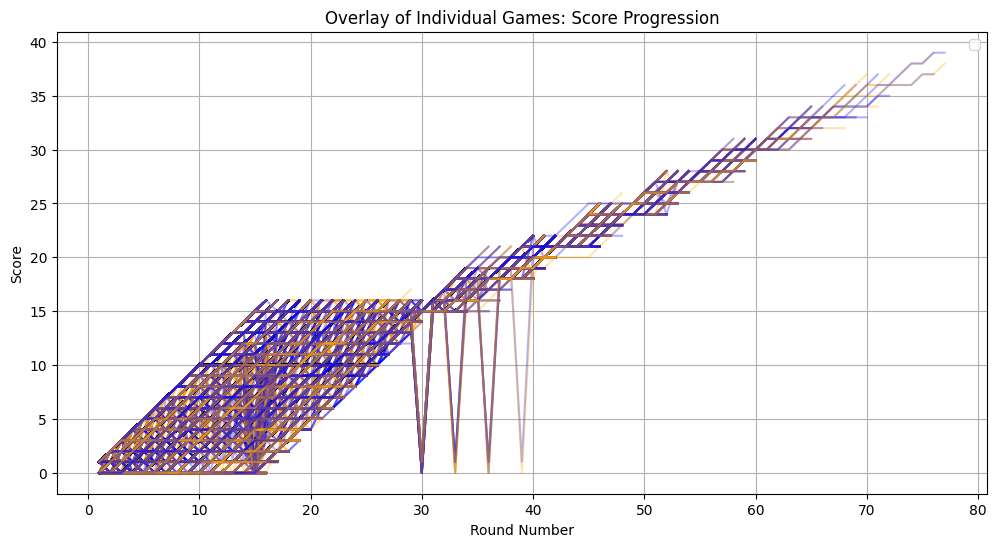

In [54]:
import matplotlib.pyplot as plt

# Filter data for unique match_id and map_number combinations
unique_games = df[['match_id', 'map_number']].drop_duplicates()

# Plot the score progression for each game
plt.figure(figsize=(12, 6))
for _, game in unique_games.iterrows():
    game_data = df[(df['match_id'] == game['match_id']) & (df['map_number'] == game['map_number'])]
    game_data = game_data.sort_values(by='round_num')
    plt.plot(game_data['round_num'], game_data['score1_end'], color='blue', alpha=0.3, label='Team 1 Score' if _ == 0 else "")
    plt.plot(game_data['round_num'], game_data['score2_end'], color='orange', alpha=0.3, label='Team 2 Score' if _ == 0 else "")

# Add labels and title
plt.title('Overlay of Individual Games: Score Progression')
plt.xlabel('Round Number')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


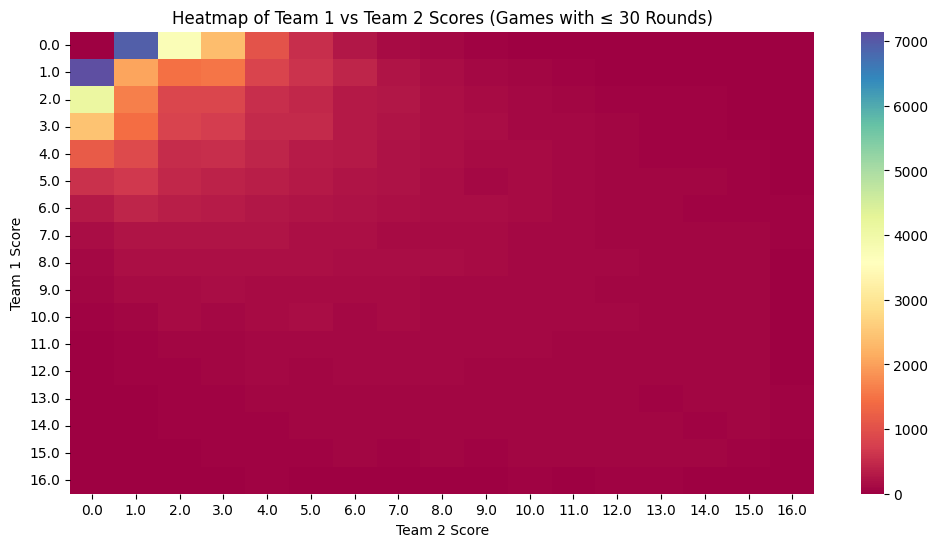

In [55]:

#log heatmap


import seaborn as sns
import matplotlib.pyplot as plt

# Filter games with a maximum of 30 rounds
filtered_games = df[df['round_num'] <= 30].drop_duplicates(subset=['match_id', 'map_number'])

# Create a pivot table for heatmap
heatmap_data = filtered_games.pivot_table(index='score1_end', columns='score2_end', aggfunc='size', fill_value=0)

# Plot the heatmap with a more colorful colormap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='Spectral', annot=False, fmt='d', cbar=True)

# Add labels and title
plt.title('Heatmap of Team 1 vs Team 2 Scores (Games with ≤ 30 Rounds)')
plt.xlabel('Team 2 Score')
plt.ylabel('Team 1 Score')
plt.show()


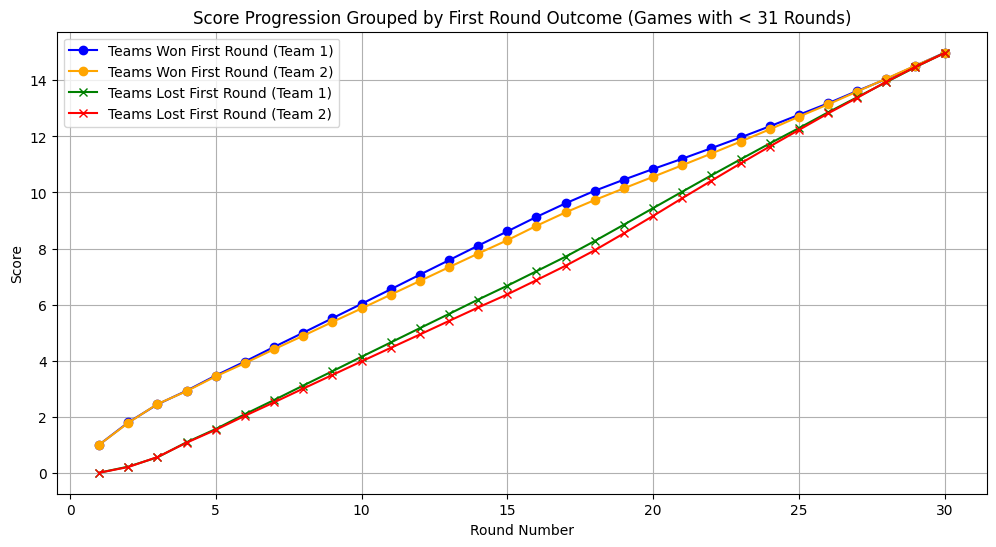

In [82]:
import matplotlib.pyplot as plt

# Filter data for games with less than 31 rounds played
filtered_df_2 = df[df['round_num'] <= 30]

# Identify the winner of the first round for each match and map
first_round_winners = filtered_df_2[filtered_df_2['round_num'] == 1][['match_id', 'map_number', 'winner_team']].rename(columns={'winner_team': 'first_round_winner'})

# Merge the first round winners back into the filtered DataFrame
filtered_df_2 = filtered_df_2.merge(first_round_winners, on=['match_id', 'map_number'], how='left')

# Add a column to indicate if the team won or lost the first round
filtered_df_2['team1_first_round_group'] = (filtered_df_2['first_round_winner'] == 1).astype(int)
filtered_df_2['team2_first_round_group'] = (filtered_df_2['first_round_winner'] == 2).astype(int)

# Filter data for score progression
score_progression = filtered_df_2[['round_num', 'score1_end', 'score2_end', 'team1_first_round_group', 'team2_first_round_group']]

# Group by first round winner and calculate average scores
grouped_scores = score_progression.groupby(['round_num', 'team1_first_round_group', 'team2_first_round_group']).mean().reset_index()

grouped_scores = grouped_scores[~((grouped_scores['team1_first_round_group'] == 0) & (grouped_scores['team2_first_round_group'] == 0))]

# Plot the score progression
plt.figure(figsize=(12, 6))

# Plot for teams that won the first round
won_first_round_1 = grouped_scores[(grouped_scores['team1_first_round_group'] == 1) ]
won_first_round_2 = grouped_scores[(grouped_scores['team2_first_round_group'] == 1) ]
plt.plot(won_first_round_1['round_num'], won_first_round_1['score1_end'], label='Teams Won First Round (Team 1)', color='blue', marker='o')
plt.plot(won_first_round_2['round_num'], won_first_round_2['score2_end'], label='Teams Won First Round (Team 2)', color='orange', marker='o')

# Plot for teams that lost the first round

plt.plot(won_first_round_2['round_num'], won_first_round_2['score1_end'], label='Teams Lost First Round (Team 1)', color='green', marker='x')
plt.plot(won_first_round_1['round_num'], won_first_round_1['score2_end'], label='Teams Lost First Round (Team 2)', color='red', marker='x')

# Add labels and title
plt.title('Score Progression Grouped by First Round Outcome (Games with < 31 Rounds)')
plt.xlabel('Round Number')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

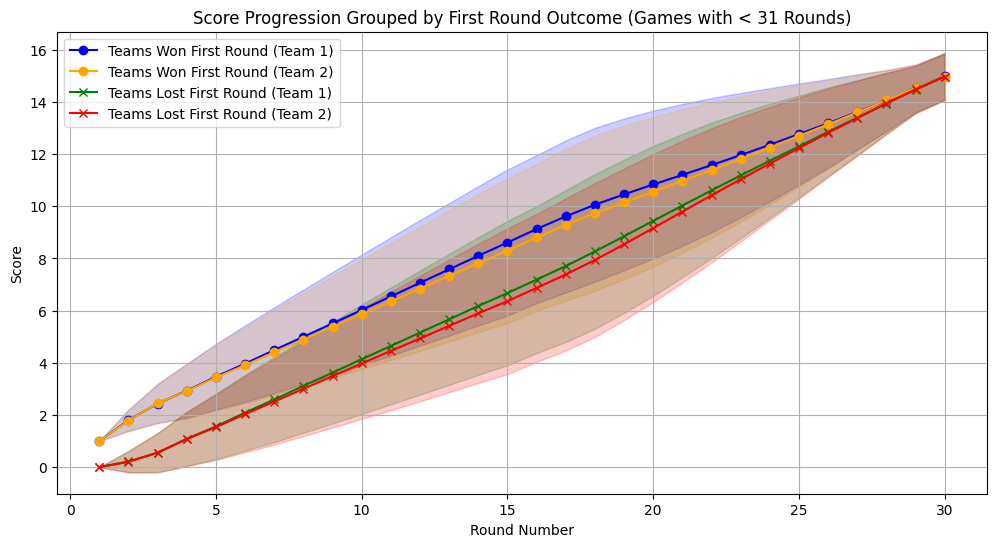

In [83]:
import matplotlib.pyplot as plt

# Filter data for games with less than 31 rounds played
filtered_df_2 = df[df['round_num'] <= 30]

# Identify the winner of the first round for each match and map
first_round_winners = filtered_df_2[filtered_df_2['round_num'] == 1][['match_id', 'map_number', 'winner_team']].rename(columns={'winner_team': 'first_round_winner'})

# Merge the first round winners back into the filtered DataFrame
filtered_df_2 = filtered_df_2.merge(first_round_winners, on=['match_id', 'map_number'], how='left')

# Add a column to indicate if the team won or lost the first round
filtered_df_2['team1_first_round_group'] = (filtered_df_2['first_round_winner'] == 1).astype(int)
filtered_df_2['team2_first_round_group'] = (filtered_df_2['first_round_winner'] == 2).astype(int)

# Filter data for score progression
score_progression = filtered_df_2[['round_num', 'score1_end', 'score2_end', 'team1_first_round_group', 'team2_first_round_group']]

# Group by first round winner and calculate average scores and standard deviation
grouped_scores = score_progression.groupby(['round_num', 'team1_first_round_group', 'team2_first_round_group']).agg(
    score1_mean=('score1_end', 'mean'),
    score1_std=('score1_end', 'std'),
    score2_mean=('score2_end', 'mean'),
    score2_std=('score2_end', 'std')
).reset_index()

# Filter out invalid groups
grouped_scores = grouped_scores[~((grouped_scores['team1_first_round_group'] == 0) & (grouped_scores['team2_first_round_group'] == 0))]

# Plot the score progression with deviation
plt.figure(figsize=(12, 6))

# Plot for teams that won the first round
won_first_round_1 = grouped_scores[grouped_scores['team1_first_round_group'] == 1]
won_first_round_2 = grouped_scores[grouped_scores['team2_first_round_group'] == 1]

plt.plot(won_first_round_1['round_num'], won_first_round_1['score1_mean'], label='Teams Won First Round (Team 1)', color='blue', marker='o')
plt.fill_between(won_first_round_1['round_num'], 
                 won_first_round_1['score1_mean'] - won_first_round_1['score1_std'], 
                 won_first_round_1['score1_mean'] + won_first_round_1['score1_std'], 
                 color='blue', alpha=0.2)

plt.plot(won_first_round_2['round_num'], won_first_round_2['score2_mean'], label='Teams Won First Round (Team 2)', color='orange', marker='o')
plt.fill_between(won_first_round_2['round_num'], 
                 won_first_round_2['score2_mean'] - won_first_round_2['score2_std'], 
                 won_first_round_2['score2_mean'] + won_first_round_2['score2_std'], 
                 color='orange', alpha=0.2)

# Plot for teams that lost the first round
lost_first_round_1 = grouped_scores[grouped_scores['team1_first_round_group'] == 0]
lost_first_round_2 = grouped_scores[grouped_scores['team2_first_round_group'] == 0]

plt.plot(lost_first_round_1['round_num'], lost_first_round_1['score1_mean'], label='Teams Lost First Round (Team 1)', color='green', marker='x')
plt.fill_between(lost_first_round_1['round_num'], 
                 lost_first_round_1['score1_mean'] - lost_first_round_1['score1_std'], 
                 lost_first_round_1['score1_mean'] + lost_first_round_1['score1_std'], 
                 color='green', alpha=0.2)

plt.plot(lost_first_round_2['round_num'], lost_first_round_2['score2_mean'], label='Teams Lost First Round (Team 2)', color='red', marker='x')
plt.fill_between(lost_first_round_2['round_num'], 
                 lost_first_round_2['score2_mean'] - lost_first_round_2['score2_std'], 
                 lost_first_round_2['score2_mean'] + lost_first_round_2['score2_std'], 
                 color='red', alpha=0.2)

# Add labels and title
plt.title('Score Progression Grouped by First Round Outcome (Games with < 31 Rounds)')
plt.xlabel('Round Number')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

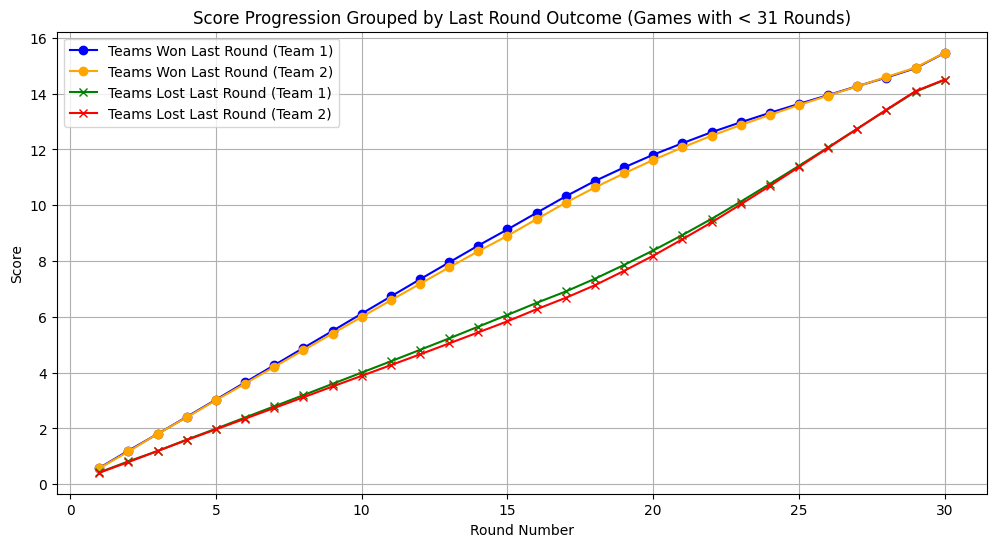

In [84]:
import matplotlib.pyplot as plt

# Filter data for games with less than 31 rounds played
filtered_df_3 = df[df['round_num'] <= 30]

max_rounds = filtered_df_3.groupby(['match_id', 'map_number'])['round_num'].max().reset_index()


# Identify the winner of the last round for each match and map
last_round_winners = filtered_df_3.merge(max_rounds, on=['match_id', 'map_number', 'round_num'], how='inner')[['match_id', 'map_number', 'winner_team']].rename(columns={'winner_team': 'last_round_winner'})


# Merge the last round winners back into the filtered DataFrame
filtered_df_3 = filtered_df_3.merge(last_round_winners, on=['match_id', 'map_number'], how='left')

# Add a column to indicate if the team won or lost the last round
filtered_df_3['team1_last_round_group'] = (filtered_df_3['last_round_winner'] == 1).astype(int)
filtered_df_3['team2_last_round_group'] = (filtered_df_3['last_round_winner'] == 2).astype(int)

# Filter data for score progression
score_progression_last = filtered_df_3[['round_num', 'score1_end', 'score2_end', 'team1_last_round_group', 'team2_last_round_group']]

# Group by last round winner and calculate average scores
grouped_scores_last = score_progression_last.groupby(['round_num', 'team1_last_round_group', 'team2_last_round_group']).mean().reset_index()

grouped_scores_last = grouped_scores_last[~((grouped_scores_last['team1_last_round_group'] == 0) & (grouped_scores_last['team2_last_round_group'] == 0))]

# Plot the score progression
plt.figure(figsize=(12, 6))

# Plot for teams that won the first round
won_last_round_1 = grouped_scores_last[(grouped_scores_last['team1_last_round_group'] == 1) ]
won_last_round_2 = grouped_scores_last[(grouped_scores_last['team2_last_round_group'] == 1) ]
plt.plot(won_last_round_1['round_num'], won_last_round_1['score1_end'], label='Teams Won Last Round (Team 1)', color='blue', marker='o')
plt.plot(won_last_round_2['round_num'], won_last_round_2['score2_end'], label='Teams Won Last Round (Team 2)', color='orange', marker='o')

# Plot for teams that lost the first round

plt.plot(won_last_round_2['round_num'], won_last_round_2['score1_end'], label='Teams Lost Last Round (Team 1)', color='green', marker='x')
plt.plot(won_last_round_1['round_num'], won_last_round_1['score2_end'], label='Teams Lost Last Round (Team 2)', color='red', marker='x')

# Add labels and title
plt.title('Score Progression Grouped by Last Round Outcome (Games with < 31 Rounds)')
plt.xlabel('Round Number')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [85]:
first_round_last_round = filtered_df_3.groupby(['match_id', 'map_number'])[['team1_last_round_group', 'team2_last_round_group']].first().reset_index()

first_round_last_round = first_round_last_round.merge(filtered_df_2, on=['match_id', 'map_number'], how='left')

#first_round_last_round = first_round_last_round.groupby(['match_id', 'map_number'])[['team1_first_round_group', 'team2_first_round_group', 'team1_last_round_group', 'team2_last_round_group']].first().reset_index()

first_round_last_round['overall_winner'] = (
    ((first_round_last_round['team1_first_round_group'] == first_round_last_round['team1_last_round_group']) |
     (first_round_last_round['team2_first_round_group'] == first_round_last_round['team2_last_round_group']))
    .astype(int)
)

percentage_overall_winner = (first_round_last_round['overall_winner'].mean()) * 100
print(f"Percentage of rows where overall_winner = 1: {percentage_overall_winner:.2f}%")

Percentage of rows where overall_winner = 1: 56.88%


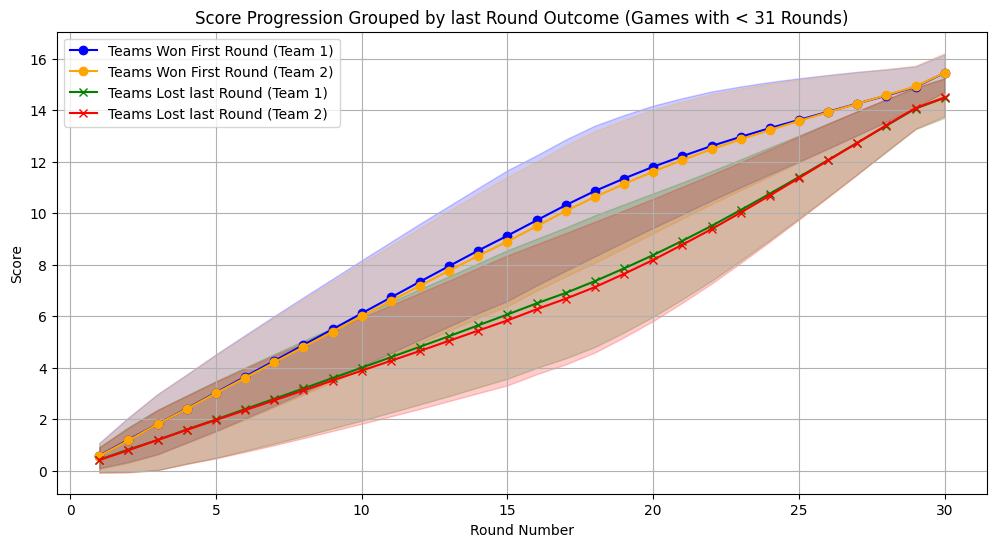

In [88]:

# Group by first round winner and calculate average scores and standard deviation
grouped_scores_last = score_progression_last.groupby(['round_num', 'team1_last_round_group', 'team2_last_round_group']).agg(
    score1_mean=('score1_end', 'mean'),
    score1_std=('score1_end', 'std'),
    score2_mean=('score2_end', 'mean'),
    score2_std=('score2_end', 'std')
).reset_index()

# Filter out invalid groups
grouped_scores_last = grouped_scores_last[~((grouped_scores_last['team1_last_round_group'] == 0) & (grouped_scores_last['team2_last_round_group'] == 0))]

# Plot the score progression with deviation
plt.figure(figsize=(12, 6))

# Plot for teams that won the first round
won_last_round_1 = grouped_scores_last[grouped_scores_last['team1_last_round_group'] == 1]
won_last_round_2 = grouped_scores_last[grouped_scores_last['team2_last_round_group'] == 1]

plt.plot(won_last_round_1['round_num'], won_last_round_1['score1_mean'], label='Teams Won First Round (Team 1)', color='blue', marker='o')
plt.fill_between(won_last_round_1['round_num'], 
                won_last_round_1['score1_mean'] - won_last_round_1['score1_std'], 
                won_last_round_1['score1_mean'] + won_last_round_1['score1_std'], 
                 color='blue', alpha=0.2)

plt.plot(won_last_round_2['round_num'], won_last_round_2['score2_mean'], label='Teams Won First Round (Team 2)', color='orange', marker='o')
plt.fill_between(won_last_round_2['round_num'], 
                won_last_round_2['score2_mean'] - won_last_round_2['score2_std'], 
                won_last_round_2['score2_mean'] + won_last_round_2['score2_std'], 
                 color='orange', alpha=0.2)

# Plot for teams that lost the first round
lost_last_round_1 = grouped_scores_last[grouped_scores_last['team1_last_round_group'] == 0]
lost_last_round_2 = grouped_scores_last[grouped_scores_last['team2_last_round_group'] == 0]

plt.plot(lost_last_round_1['round_num'], lost_last_round_1['score1_mean'], label='Teams Lost last Round (Team 1)', color='green', marker='x')
plt.fill_between(lost_last_round_1['round_num'], 
                 lost_last_round_1['score1_mean'] - lost_last_round_1['score1_std'], 
                 lost_last_round_1['score1_mean'] + lost_last_round_1['score1_std'], 
                 color='green', alpha=0.2)

plt.plot(lost_last_round_2['round_num'], lost_last_round_2['score2_mean'], label='Teams Lost last Round (Team 2)', color='red', marker='x')
plt.fill_between(lost_last_round_2['round_num'], 
                 lost_last_round_2['score2_mean'] - lost_last_round_2['score2_std'], 
                 lost_last_round_2['score2_mean'] + lost_last_round_2['score2_std'], 
                 color='red', alpha=0.2)

# Add labels and title
plt.title('Score Progression Grouped by last Round Outcome (Games with < 31 Rounds)')
plt.xlabel('Round Number')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [90]:
# Create new columns for winner_last_score_end and loser_last_score_end
filtered_df_3['winner_last_score_end'] = filtered_df_3.apply(
    lambda row: row['score1_end'] if row['team1_last_round_group'] == 1 else row['score2_end'], axis=1
)

filtered_df_3['loser_last_score_end'] = filtered_df_3.apply(
    lambda row: row['score2_end'] if row['team1_last_round_group'] == 1 else row['score1_end'], axis=1
)

# Display the first few rows of the updated DataFrame
print(filtered_df_3[['round_num', 'score1_end', 'score2_end', 'team1_last_round_group', 'winner_last_score_end', 'loser_last_score_end']].head())

   round_num  score1_end  score2_end  team1_last_round_group  \
0         16         9.0         7.0                       0   
1         17         5.0        12.0                       0   
2         16         4.0        12.0                       0   
3         19         6.0        13.0                       0   
4         19        10.0         9.0                       0   

   winner_last_score_end  loser_last_score_end  
0                    7.0                   9.0  
1                   12.0                   5.0  
2                   12.0                   4.0  
3                   13.0                   6.0  
4                    9.0                  10.0  


C:\Users\peter\AppData\Local\Temp\ipykernel_84212\3629888214.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


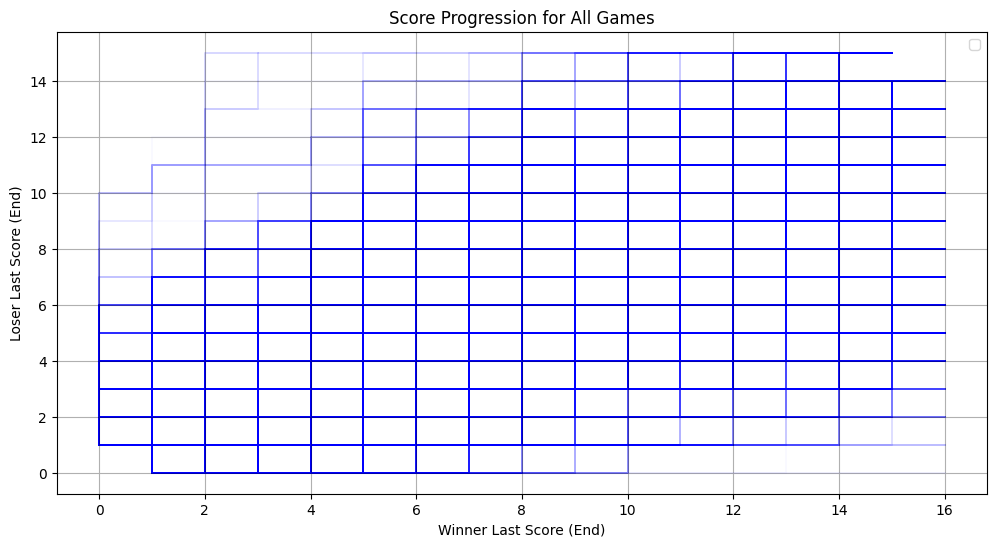

In [92]:



# Plot the score progression for each game
plt.figure(figsize=(12, 6))
for i, game in filtered_df_3.iterrows():
    game_data = filtered_df_3[(filtered_df_3['match_id'] == game['match_id']) & (filtered_df_3['map_number'] == game['map_number'])]
    game_data = game_data.sort_values(by='round_num')
    plt.plot(game_data['winner_last_score_end'], game_data['loser_last_score_end'], "b",alpha=0.01, label='Game Progression' if _ == 0 else "")
    if i > 5000:
        break

# Add labels and title
plt.title('Score Progression for All Games')
plt.xlabel('Winner Last Score (End)')
plt.ylabel('Loser Last Score (End)')
plt.legend()
plt.grid(True)
plt.show()
